In [7]:
#导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [8]:
#设置LSTM的时间窗等参数
window=5
lstm_units = 16
dropout = 0.01
epochs=60
batch_size = 256
#读取数据
df1=pd.read_csv('data.csv') 

df1=df1.iloc[:,2:]
df1.tail()

,open,low,close,high
26272,7.1042,7.1042,7.1048,7.1055
26273,7.1047,7.1038,7.1038,7.1047
26274,7.1039,7.1039,7.1046,7.1047
26275,7.1048,7.1043,7.1045,7.1049
26276,7.1049,7.1049,7.1057,7.1057


In [9]:
#进行数据归一化
scaler = MinMaxScaler()
df0=scaler.fit_transform(df1)
df = pd.DataFrame(df0, columns=df1.columns)

# input_size=len(df.iloc[1,:])
# print(input_size)

In [10]:
#构建lstm输入
stock=df
seq_len=window
amount_of_features = len(stock.columns)#有几列
data = stock.values #pd.DataFrame(stock) 表格转化为矩阵

sequence_length = seq_len + 1#序列长度

result = []
for index in range(len(data) - sequence_length):#循环数据长度-sequence_length次
    result.append(data[index: index + sequence_length])#第i行到i+sequence_length
result = np.array(result)#得到样本，样本形式为6天*3特征
row = round(0.9 * result.shape[0])#划分训练集测试集
train = result[:int(row), :]
x_train = train[:, :-1]
y_train = train[:, -1][:,-1]
x_test = result[int(row):, :-1]
y_test = result[int(row):, -1][:,-1]

# 转化成pytorch张量
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# 创建DataLoader
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
#建立LSTM模型 训练
# 定义模型
class CNNLSTMAttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob):
        super(CNNLSTMAttentionModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.conv1d = nn.Conv1d(in_channels=input_dim, out_channels=hidden_dim, kernel_size=1)
        self.maxpool1d = nn.MaxPool1d(kernel_size=window)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.lstm = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(2 * hidden_dim, 2 * hidden_dim)
        self.fc = nn.Linear(2 * hidden_dim, output_dim)
    
    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch_size, input_dim, window)
        x = self.conv1d(x)      # (batch_size, hidden_dim, window)
        x = self.maxpool1d(x)   # (batch_size, hidden_dim, 1)
        x = x.permute(0, 2, 1)  # (batch_size, 1, hidden_dim)
        x = self.dropout(x)
        x, (h_n, c_n) = self.lstm(x)  # (batch_size, 1, 2*hidden_dim)
        attention_weights = torch.softmax(self.attention(x), dim=2)
        x = x * attention_weights
        x = x.sum(dim=1)  # (batch_size, 2*hidden_dim)
        x = self.fc(x)
        return x

In [12]:
# 初始化模型
model = CNNLSTMAttentionModel(input_dim=x_train.shape[2], hidden_dim=lstm_units, output_dim=1, dropout_prob=dropout)


In [13]:
# 损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
for epoch in range(epochs):
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# 测试模型
model.eval()
with torch.no_grad():
    y_train_predict = model(x_train).detach().numpy()
    y_test_predict = model(x_test).detach().numpy()


Epoch [1/60], Loss: 0.2029
Epoch [2/60], Loss: 0.0575
Epoch [3/60], Loss: 0.0297
Epoch [4/60], Loss: 0.0196
Epoch [5/60], Loss: 0.0060
Epoch [6/60], Loss: 0.0017
Epoch [7/60], Loss: 0.0011
Epoch [8/60], Loss: 0.0004
Epoch [9/60], Loss: 0.0014
Epoch [10/60], Loss: 0.0002
Epoch [11/60], Loss: 0.0001
Epoch [12/60], Loss: 0.0007
Epoch [13/60], Loss: 0.0003
Epoch [14/60], Loss: 0.0003
Epoch [15/60], Loss: 0.0007
Epoch [16/60], Loss: 0.0009
Epoch [17/60], Loss: 0.0003
Epoch [18/60], Loss: 0.0003
Epoch [19/60], Loss: 0.0005
Epoch [20/60], Loss: 0.0002
Epoch [21/60], Loss: 0.0008
Epoch [22/60], Loss: 0.0009
Epoch [23/60], Loss: 0.0003
Epoch [24/60], Loss: 0.0003
Epoch [25/60], Loss: 0.0006
Epoch [26/60], Loss: 0.0004
Epoch [27/60], Loss: 0.0003
Epoch [28/60], Loss: 0.0005
Epoch [29/60], Loss: 0.0004
Epoch [30/60], Loss: 0.0003
Epoch [31/60], Loss: 0.0007
Epoch [32/60], Loss: 0.0003
Epoch [33/60], Loss: 0.0004
Epoch [34/60], Loss: 0.0005
Epoch [35/60], Loss: 0.0002
Epoch [36/60], Loss: 0.0006
E

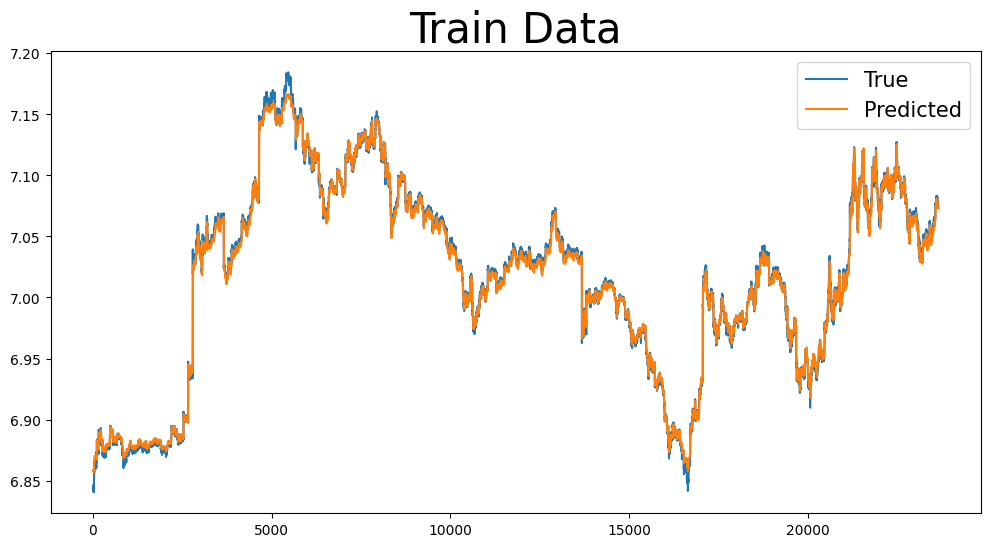

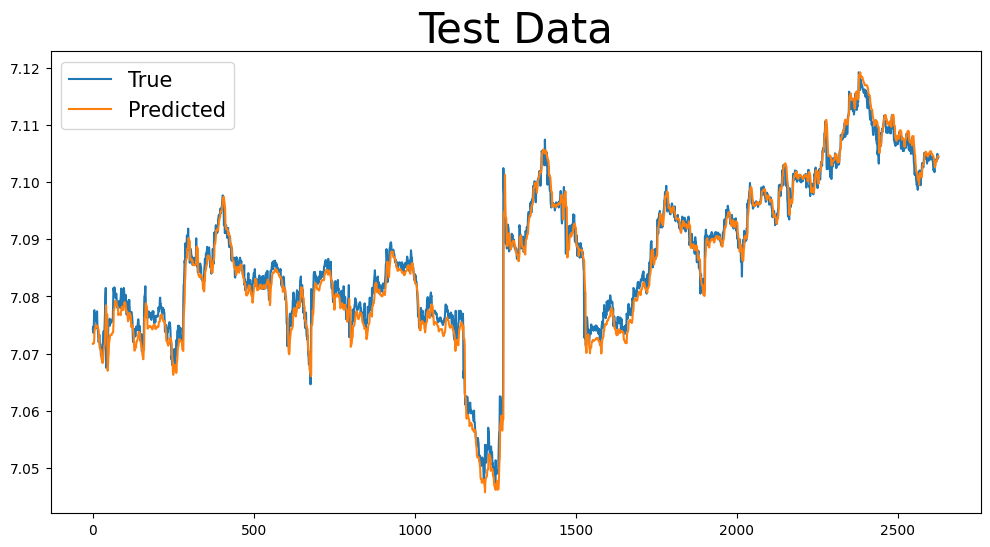

训练集上的MAE/MSE/MAPE/涨跌准确率
0.0024684494110193884
1.2718575549615124e-05
0.03513266005051353
0.4672841855940448
测试集上的MAE/MSE/MAPE/涨跌准确率
0.0016047076266370967
5.164611708622718e-06
0.02265201828180028
0.4497334348819497


In [14]:
# 反归一化
y_train = scaler.inverse_transform(np.concatenate((y_train.view(-1, 1), np.zeros((y_train.size(0), x_train.shape[2]-1))), axis=1))[:, 0]
y_test = scaler.inverse_transform(np.concatenate((y_test.view(-1, 1), np.zeros((y_test.size(0), x_test.shape[2]-1))), axis=1))[:, 0]
y_train_predict = scaler.inverse_transform(np.concatenate((y_train_predict, np.zeros((y_train_predict.shape[0], x_train.shape[2]-1))), axis=1))[:, 0]
y_test_predict = scaler.inverse_transform(np.concatenate((y_test_predict, np.zeros((y_test_predict.shape[0], x_train.shape[2]-1))), axis=1))[:, 0]

# 绘制图像
def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='True')
    plt.plot(y_pred, label='Predicted')
    plt.title(title, fontsize=30)
    plt.legend(fontsize=15)
    plt.show()

plot_results(y_train, y_train_predict, 'Train Data')
plot_results(y_test, y_test_predict, 'Test Data')

# 输出结果
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

def up_down_accuracy(y_true, y_pred):
    y_var_test = y_true[1:] - y_true[:-1]
    y_var_predict = y_pred[1:] - y_pred[:-1]
    accuracy = np.mean((np.sign(y_var_test) == np.sign(y_var_predict)).astype(int))
    return accuracy

print('训练集上的MAE/MSE/MAPE/涨跌准确率')
print(mean_absolute_error(y_train, y_train_predict))
print(mean_squared_error(y_train, y_train_predict))
print(mape(y_train, y_train_predict))
print(up_down_accuracy(y_train, y_train_predict))

print('测试集上的MAE/MSE/MAPE/涨跌准确率')
print(mean_absolute_error(y_test, y_test_predict))
print(mean_squared_error(y_test, y_test_predict))
print(mape(y_test, y_test_predict))
print(up_down_accuracy(y_test, y_test_predict))